# Denoising of Single EM Image

**Created on:** 23/10/2024  
**Author:** Dmitry Chezganov  

This notebook processes a single Electron Microscopy (EM) image by applying denoising techniques using custom neural network-based functions. The NN was develoed by Ivan Lobato and can be found at [https://github.com/Ivanlh20/tk_r_em](https://github.com/Ivanlh20/tk_r_em) as well as the details of installation procedure.
 
 The main steps include:

- Importing the necessary libraries and custom functions (`NN_denois_functions` and `hyperspy`)
- Specifying the image file to be denoised and setting the output directory for results
- Configuring the maximum image size for GPU-based denoising
- Loading and visualizing the image before and after denoising

The goal of this notebook is to improve the quality of the EM image for further analysis by removing noise while preserving essential details.



## Import libraries

In [1]:
import NN_denois_functions as nn
import hyperspy.api as hs

2024-10-23 22:27:21.975822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Indicate path to teh .dm3 image file and path to save results

In [3]:
# * Specify the file to denoise
image_file = '/Users/dmitrychezganov/Library/CloudStorage/SynologyDrive-Macbook1/Work_EMAT/Images4segmentation/EBIC_Sara/Sample 4/001_512x512_320kx_500us_250pA.dm3'
# image_file = '/Volumes/industry/industry08/Microscope_data/Request 2024-05 (TiS2)/20240621 (TiS2_SSE_70_30 Osiris)/TEM_STEM/TEM/14.05.03 CCD Acquire.emi'
# * Specify the folder to save the results
output_folder = '/Users/dmitrychezganov/Library/CloudStorage/SynologyDrive-Macbook1/Work_EMAT/Images4segmentation/EBIC_Sara/Sample 4/denoising_single image/'

# * Output folder
folder_to_save = nn.make_folder(output_folder, 'denoised_images')

Successfully created the directory /Users/dmitrychezganov/Library/CloudStorage/SynologyDrive-Macbook1/Work_EMAT/Images4segmentation/EBIC_Sara/Sample 4/denoising_single image/denoised_images


## Use patch-based method if x or y dimension is larger than max_size_gpum

In [4]:
# max_size_gpu = 1024
max_size_gpu = 1024
print(f'Maximum image size which fits into GPU memory: {max_size_gpu}')

Maximum image size which fits into GPU memory: 1024


## Image loading

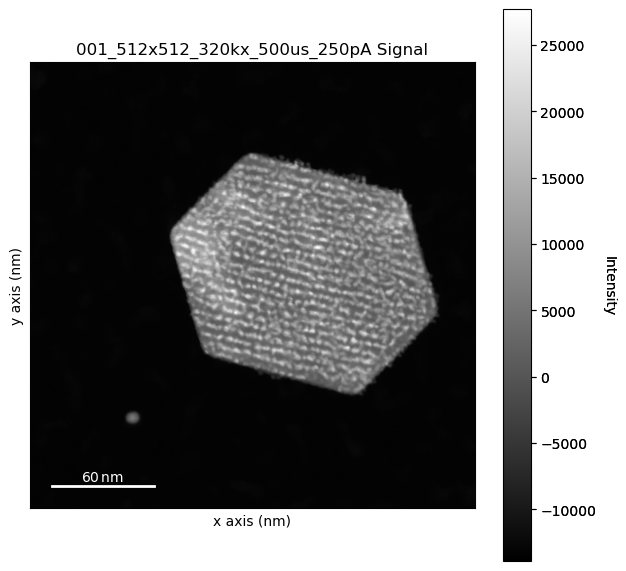

In [7]:
%matplotlib inline
s = nn.hs.load(image_file)
s.inav[1].plot()

## Run denoising and saving in various formats

In [11]:

# ! Set GPU ID
nn.fcn_set_gpu_id("0")

# valid_models = ['sfr_hrstem', 'sfr_lrstem', 'sfr_hrsem', 'sfr_lrsem', 'sfr_hrtem', 'sfr_lrtem']
# * Choose denoising model
net_name = 'sfr_hrstem'

# * Load the network
print(f'Model: {net_name}')
print('Loading network...')
r_em_nn = nn.load_network(net_name)

print('Denoising images...')
filename = nn.os.path.basename(image_file)
filename= filename[:-4]
print(f'Image name: {filename}')
# short name to put on the images
filename_short = filename.split('_')[0]
img, img_adj, px_size, mag, HT, unit, scale, _ = nn.check_and_load_image(image_file, file_data_0=s, file_data=s)
# * Check image size
nx, ny = img.shape
print(f'Image size: {nx} x {ny}')
# expand dimensions since for some reason it is needed
image = nn.np.expand_dims(img, axis=(0, -1)) # this is used for denoising
# * Denoise image
denoised_image = nn.denoise_image(image,
                                    net = r_em_nn, 
                                    nx=nx, 
                                    ny=ny, 
                                    max_size_gpu = max_size_gpu
                                    )
# * Plot comparison
nn.plot_original_vs_denoised(original_image=img_adj,
                                denoised_image=denoised_image,
                                net_name=net_name,
                                cmap='gray',
                                save_path=folder_to_save,
                                show=True
                                )
# ! Check options for image saving
# * Flags
save_32bit_tif = True
save_16bit_tif_png_scalerbar_original = True
save_16bit_tif_png_scalerbar_denoised = True
save_fft = True

# * Make fft comparison
nn.apply_fft_and_plot(file_name=filename,
                        image=img_adj,
                        denoised_image=denoised_image,
                        net_name=net_name,
                        save_path_png=folder_to_save,
                        save_path_fft_comparison=folder_to_save,
                        show=True, 
                        save_fft=save_fft
                        )

# * Save denoised image
# save denoised images as 32 tif
if save_32bit_tif==True:
    nn.save_tif_32bit_image_denoised(image=denoised_image,
                                        file_name=filename, 
                                        outputpath=folder_to_save, 
                                        pixelsize=px_size,
                                        unit=unit,
                                        model_name=net_name
                                        )
    # save original images as 32 tif
    nn.save_tif_32bit_image_original(image=img_adj,
                                        file_name=filename, 
                                        outputpath=folder_to_save, 
                                        pixelsize=px_size,
                                        unit=unit,
                                        model_name=net_name
                                        )
if save_16bit_tif_png_scalerbar_denoised==True:
# save denoised images as 16bit tif and 8bit png with scalebar
    nn.save_tif_png_16bit_image_with_scalebar(image=denoised_image,
                                            save_path_tif16bit=folder_to_save,
                                            save_path_png=folder_to_save,
                                            file_name=filename+'_denoised',
                                            px_size=px_size,
                                            mag=mag,
                                            HT=HT,
                                            units=unit,
                                            show=True
                                            )
if save_16bit_tif_png_scalerbar_original==True:
# save original images as 16bit tif and 8bit png with scalebar
    nn.save_tif_png_16bit_image_with_scalebar(image=img_adj,
                                            save_path_tif16bit=folder_to_save,
                                            save_path_png=folder_to_save,
                                            file_name=filename+'_original',
                                            px_size=px_size,
                                            mag=mag,
                                            HT=HT,
                                            units=unit,
                                            show=True
                                            )
print('#####################')
print('Denoising is finished!')

Model: sfr_hrstem
Loading network...
Denoising images...
Image name: 001_512x512_320kx_500us_250pA
File /Users/dmitrychezganov/Library/CloudStorage/SynologyDrive-Macbook1/Work_EMAT/Images4segmentation/EBIC_Sara/Sample 4/001_512x512_320kx_500us_250pA.dm3 is not a TIFF image. It is .emi file. Using the hyperspy to load the data...
ndim > 2. Using the first image from the stack...
Image size: 512 x 512


2024-10-23 22:49:16.230306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


TypeError: plot_original_vs_denoised() missing 1 required positional argument: 'file_name'